# 0. Install Dependencies and Bring in Data

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [71]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [72]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [73]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [5]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            0.15.0
alabaster                          0.7.12
anaconda-client                    1.9.0
anaconda-navigator                 2.1.1
anaconda-project                   0.10.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
arrow                              0.13.1
asn1crypto                         1.4.0
astroid                            2.6.6
astropy                            4.3.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              21.2.0
autopep8                           1.5.7
Babel                              2.9.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.4
backports.shutil-get-terminal-size

In [74]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [75]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [76]:
MAX_FEATURES = 200000 # number of words in the vocab

In [77]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [78]:
vectorizer.adapt(X.values)

In [79]:
vectorized_text = vectorizer(X.values)

In [80]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [81]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [83]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [84]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [85]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          6400032   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 774       
Total params: 6,491,686
Trainable params: 6,491,686
Non-trainable params: 0
____________________________________________

In [86]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 6080s 870ms/step - loss: 0.0646 - val_loss: 0.0460


In [87]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

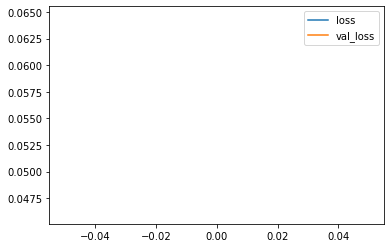

In [88]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [89]:
input_text = vectorizer(['You freaking suck! I am going to hit you.'])

In [90]:
res = model.predict(input_text)

In [91]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [92]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [93]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [94]:
res.shape

(1, 6)

# 4. Evaluate Model

In [95]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [96]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [97]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [98]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8454873561859131, Recall:0.6338294744491577, Accuracy:0.476429283618927


# 5. Test



In [102]:
model.save('toxicity.h5')

In [103]:
model = tf.keras.models.load_model('toxicity.h5')

In [104]:
input_str = vectorizer(['hey i freaken hate you!'])

In [105]:
res = model.predict(input_str)

In [106]:
res

array([[0.5384474 , 0.00698623, 0.19105172, 0.01034522, 0.20822689,
        0.03141186]], dtype=float32)

In [107]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text